In [1]:
# @title
from IPython.display import display, HTML

display(HTML("""
<script>
const firstCell = document.querySelector('.cell.code_cell');
if (firstCell) {
  firstCell.querySelector('.input').style.pointerEvents = 'none';
  firstCell.querySelector('.input').style.opacity = '0.5';
}
</script>
"""))

html = """
<div style="display:flex; flex-direction:column; align-items:center; text-align:center; gap:12px; padding:8px;">
  <h1 style="margin:0;">👋 Welcome to <span style="color:#1E88E5;">Algopath Coding Academy</span>!</h1>

  <img src="https://raw.githubusercontent.com/sshariqali/mnist_pretrained_model/main/algopath_logo.jpg"
       alt="Algopath Coding Academy Logo"
       width="400"
       style="border-radius:15px; box-shadow:0 4px 12px rgba(0,0,0,0.2); max-width:100%; height:auto;" />

  <p style="font-size:16px; margin:0;">
    <em>Empowering young minds to think creatively, code intelligently, and build the future with AI.</em>
  </p>
</div>
"""

display(HTML(html))

## **Part 1: The Assembly Line – Data Preprocessing & Pipeline**

**Objective**
Build a robust data preprocessing pipeline for sequence data to prepare it for training a language model. In Part 1, you will:

- Learn how to tokenize raw text and build vocabulary mappings (word ↔ index)
- Create input-target pairs using a sliding window approach for next word prediction
- Handle variable-length sequences using padding and attention masks
- Construct efficient PyTorch Datasets and DataLoaders for batching and shuffling
---

### **1. Introduction to Sequence Data**

**What is Sequence Data?**

Unlike the tabular data we worked with in previous days (where each row was independent), **sequence data** has an inherent order where the position of each element matters. Examples include:
- Text: "To be or not to be"
- Time series: Stock prices over time
- DNA sequences: "ATCGATCG"

**Our Goal: Next Word Prediction**

We want to build a model that can predict the next word given previous words. Mathematically, we're trying to estimate:

$$P(w_t | w_{t-1}, w_{t-2}, ..., w_{t-n})$$

Where:
- $w_t$ is the word we want to predict (at position $t$)
- $w_{t-1}, w_{t-2}, ..., w_{t-n}$ are the previous words (context)

For example:
- **Input:** "To be or not to"
- **Output:** "be" (the next word)

<div align="center">
  <img src="https://camo.githubusercontent.com/5840714d7f7d8283b758b40c08a1c5423768fed426be28a69153db6cf7d45c04/68747470733a2f2f626c6f676765722e676f6f676c6575736572636f6e74656e742e636f6d2f696d672f612f41567658734569456173376a454c454232374964786c4a34466a39726d506638783554652d6e4d5874714751566b4e566856475f62496c2d787252747653726f4a534b6634526270586b32317a5a334663664d4d34306a5f4765793749726f56596a6c624f36445865324e55475a775546355036624f6571565f36716566734d6451594a66724c627461685475304e3257754e616437775a712d6a7a684c564e744a414f73664a587a757441546b6775434d325a64394d68484e65364850617556394d533d77313230302d6831323030" width="600"/>
</div>

This is the foundation of language models like ChatGPT!

### **2. The Dataset: Tiny Shakespeare**

We'll use a collection of Shakespeare's works as our training data. This dataset is perfect for learning because:
- It's small enough to train quickly
- It has consistent style and vocabulary
- It demonstrates the challenge of long-range dependencies in text

Let's start by loading and exploring the data!

In [1]:
# Import necessary libraries
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import urllib.request

# Check PyTorch version and device
print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU")

PyTorch version: 2.9.0+cu126
Using device: cuda
GPU: Tesla T4


In [2]:
# Download the Tiny Shakespeare dataset
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
filename = 'tinyshakespeare.txt'

try:
    urllib.request.urlretrieve(url, filename)
    print(f"✓ Downloaded {filename}")
except Exception as e:
    print(f"Error downloading file: {e}")
    
# Load the text data
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"\n✓ Loaded text data")
print(f"Total characters: {len(text):,}")
print(f"\nFirst 500 characters:")
print("-" * 80)
print(text[:500])
print("-" * 80)

✓ Downloaded tinyshakespeare.txt

✓ Loaded text data
Total characters: 1,115,394

First 500 characters:
--------------------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor
--------------------------------------------------------------------------------


**Tokenization: Converting Text to Numbers**

Neural networks can't process text directly—they need numbers. **Tokenization** is the process of:
1. Splitting text into units (words, subwords, or characters)
2. Creating a mapping from tokens to unique integers
3. Converting text sequences into sequences of integers

For this notebook, we'll use **word-level tokenization** (splitting by spaces and punctuation).

**Building the Vocabulary**

The vocabulary is our "dictionary" that maps:
- **word → index** (word2idx): Used during training to convert words to numbers
- **index → word** (idx2word): Used during generation to convert numbers back to words

We'll also add three special tokens:
- `<PAD>`: Padding token (for making sequences the same length)
- `<UNK>`: Unknown token (for words not in our vocabulary)
- `<EOS>`: End of sequence token

In [3]:
# Simple tokenization: split on whitespace and basic punctuation
import re

def simple_tokenize(text):
    """
    Basic word tokenization that splits on whitespace and handles punctuation.
    """
    # Convert to lowercase
    text = text.lower()
    # Add spaces around punctuation
    text = re.sub(r'([.,!?;:])', r' \1 ', text)
    # Split on whitespace
    tokens = text.split()
    return tokens

# Tokenize the entire text
tokens = simple_tokenize(text)
print(f"Total tokens: {len(tokens):,}")
print(f"Unique tokens: {len(set(tokens)):,}")
print(f"\nFirst 50 tokens:")
print(tokens[:50])

Total tokens: 249,435
Unique tokens: 13,388

First 50 tokens:
['first', 'citizen', ':', 'before', 'we', 'proceed', 'any', 'further', ',', 'hear', 'me', 'speak', '.', 'all', ':', 'speak', ',', 'speak', '.', 'first', 'citizen', ':', 'you', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish', '?', 'all', ':', 'resolved', '.', 'resolved', '.', 'first', 'citizen', ':', 'first', ',', 'you', 'know', 'caius', 'marcius', 'is', 'chief']


In [4]:
# Build vocabulary: word to index and index to word mappings
def build_vocabulary(tokens, max_vocab_size):
    """
    Build vocabulary from tokens, keeping only the most frequent words.
    
    Args:
        tokens: List of tokens
        max_vocab_size: Maximum vocabulary size (excluding special tokens)
    
    Returns:
        word2idx: Dictionary mapping words to indices
        idx2word: Dictionary mapping indices to words
    """
    # Count word frequencies
    word_counts = Counter(tokens)
    
    # Get most common words
    most_common = word_counts.most_common(max_vocab_size)
    
    # Create vocabulary with special tokens
    vocab = ['<PAD>', '<UNK>', '<EOS>'] + [word for word, _ in most_common]
    
    # Create mappings
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    return word2idx, idx2word

# Build vocabulary
word2idx, idx2word = build_vocabulary(tokens, max_vocab_size = len(set(tokens)))
vocab_size = len(word2idx)

print(f"Vocabulary size: {vocab_size:,}")
print(f"\nSpecial tokens:")
print(f"  <PAD> → {word2idx['<PAD>']}")
print(f"  <UNK> → {word2idx['<UNK>']}")
print(f"  <EOS> → {word2idx['<EOS>']}")
print(f"\nFirst 20 words in vocabulary:")
print([idx2word[i] for i in range(3, 23)])

Vocabulary size: 13,391

Special tokens:
  <PAD> → 0
  <UNK> → 1
  <EOS> → 2

First 20 words in vocabulary:
[',', ':', '.', 'the', 'and', 'to', 'i', 'of', ';', 'you', 'my', 'a', 'that', '?', 'in', '!', 'is', 'not', 'for', 'with']


In [5]:
# Convert tokens to indices
def tokens_to_indices(tokens, word2idx):
    """
    Convert a list of tokens to a list of indices.
    Unknown words are mapped to <UNK>.
    """
    return [word2idx.get(token, word2idx['<UNK>']) for token in tokens]

# Convert our tokens to indices
token_indices = tokens_to_indices(tokens, word2idx)

print(f"Total token indices: {len(token_indices):,}")
print(f"\nExample conversion:")
print(f"Tokens:  {tokens[:10]}")
print(f"Indices: {token_indices[:10]}")
print(f"\nVerifying back-conversion:")
print(f"Back to words: {[idx2word[idx] for idx in token_indices[:10]]}")

Total token indices: 249,435

Example conversion:
Tokens:  ['first', 'citizen', ':', 'before', 'we', 'proceed', 'any', 'further', ',', 'hear']
Indices: [95, 275, 4, 145, 43, 974, 148, 670, 3, 132]

Verifying back-conversion:
Back to words: ['first', 'citizen', ':', 'before', 'we', 'proceed', 'any', 'further', ',', 'hear']


### **3. The Custom Dataset Class**

**What is a PyTorch Dataset?**

PyTorch provides a `torch.utils.data.Dataset` class that helps organize data for training. A custom dataset must implement three methods:
1. `__init__`: Initialize the dataset (load data, set parameters)
2. `__len__`: Return the number of samples in the dataset
3. `__getitem__`: Return a single sample (input and target) at a given index

**The Sliding Window Approach**

To train our model, we need to create input-target pairs from our sequence of tokens. We use a "sliding window" that moves through the text:

```
Full sequence: "to be or not to be that is the question"
Window size: 5

Window 1:
  Input:  "to be or not to"
  Target: "be or not to be"

Window 2:
  Input:  "be or not to be"
  Target: "or not to be that"

Window 3:
  Input:  "or not to be that"
  Target: "not to be that is"
...
```

Notice that:
- The **input** is a sequence of `n` words
- The **target** is the same sequence shifted by 1 position (the next word for each position)
- The model learns to predict each word based on all previous words in the sequence

Let's implement this!

In [6]:
class ShakespeareDataset(Dataset):
    """
    Custom Dataset for the Tiny Shakespeare text.
    Creates input-target pairs using a sliding window approach.
    """
    
    def __init__(self, token_indices, seq_length):
        """
        Initialize the dataset.
        
        Args:
            token_indices: List of token indices (already converted from words)
            seq_length: Length of each sequence (window size)
        """
        self.token_indices = token_indices
        self.seq_length = seq_length
        
        # Calculate how many sequences we can create
        # We need seq_length + 1 tokens for each sample (input + target)
        self.num_sequences = len(token_indices) - seq_length
        
    def __len__(self):
        """
        Return the total number of sequences in the dataset.
        """
        return self.num_sequences
    
    def __getitem__(self, idx):
        """
        Get a single input-target pair.
        
        Args:
            idx: Index of the sequence to retrieve
            
        Returns:
            input_seq: Tensor of input token indices
            target_seq: Tensor of target token indices (shifted by 1)
        """
        # Extract a window of seq_length + 1 tokens
        sequence = self.token_indices[idx:idx + self.seq_length + 1]
        
        # Split into input and target
        input_seq = torch.tensor(sequence[:-1], dtype=torch.long)   # First seq_length tokens
        target_seq = torch.tensor(sequence[1:], dtype=torch.long)   # Last seq_length tokens
        
        return input_seq, target_seq

# Create dataset with sequence length of 20
seq_length = 20
dataset = ShakespeareDataset(token_indices, seq_length)

print(f"Dataset created!")
print(f"Sequence length: {seq_length}")
print(f"Total sequences: {len(dataset):,}")
print(f"\nEach sequence consists of:")
print(f"  - Input: {seq_length} tokens")
print(f"  - Target: {seq_length} tokens (shifted by 1)")

Dataset created!
Sequence length: 20
Total sequences: 249,415

Each sequence consists of:
  - Input: 20 tokens
  - Target: 20 tokens (shifted by 1)


In [7]:
# Let's examine a few samples to understand the sliding window
print("Example sequences from the dataset:\n")

for i in range(3):
    input_seq, target_seq = dataset[i]
    
    # Convert indices back to words for visualization
    input_words = [idx2word[idx.item()] for idx in input_seq]
    target_words = [idx2word[idx.item()] for idx in target_seq]
    
    print(f"Sample {i+1}:")
    print(f"  Input:  {' '.join(input_words)}")
    print(f"  Target: {' '.join(target_words)}")
    print(f"  Indices (first 10): {input_seq[:10].tolist()}")
    print()

# Verify the relationship between input and target
input_seq, target_seq = dataset[0]
print("Detailed view of the first sample:")
print(f"{'Position':<10} {'Input Word':<15} {'Target Word':<15}")
print("-" * 40)
for i in range(min(10, len(input_seq))):
    print(f"{i:<10} {idx2word[input_seq[i].item()]:<15} {idx2word[target_seq[i].item()]:<15}")

Example sequences from the dataset:

Sample 1:
  Input:  first citizen : before we proceed any further , hear me speak . all : speak , speak . first
  Target: citizen : before we proceed any further , hear me speak . all : speak , speak . first citizen
  Indices (first 10): [95, 275, 4, 145, 43, 974, 148, 670, 3, 132]

Sample 2:
  Input:  citizen : before we proceed any further , hear me speak . all : speak , speak . first citizen
  Target: : before we proceed any further , hear me speak . all : speak , speak . first citizen :
  Indices (first 10): [275, 4, 145, 43, 974, 148, 670, 3, 132, 23]

Sample 3:
  Input:  : before we proceed any further , hear me speak . all : speak , speak . first citizen :
  Target: before we proceed any further , hear me speak . all : speak , speak . first citizen : you
  Indices (first 10): [4, 145, 43, 974, 148, 670, 3, 132, 23, 111]

Detailed view of the first sample:
Position   Input Word      Target Word    
----------------------------------------
0   

### **4. Handling Variable Lengths: The collate_fn**

**The Problem: Variable Sequence Lengths**

In real-world scenarios, text sequences often have different lengths:
- "Hello" (1 word)
- "To be or not to be" (6 words)
- "The quick brown fox jumps over the lazy dog" (9 words)

However, neural networks process data in **batches** (multiple samples at once for efficiency), and tensors in a batch must have the same shape. We can't stack these sequences into a single tensor:

```python
# This won't work!
batch = [
    [1, 2, 3],           # length 3
    [4, 5, 6, 7, 8],     # length 5
    [9, 10]              # length 2
]
# → Cannot create a rectangular tensor!
```

**The Solution: Padding**

We solve this by **padding** shorter sequences with a special `<PAD>` token (index 0) to match the longest sequence in the batch:

```python
# After padding to length 5:
batch = [
    [1, 2, 3, 0, 0],     # length 3 → padded with 2 zeros
    [4, 5, 6, 7, 8],     # length 5 → no padding needed
    [9, 10, 0, 0, 0]     # length 2 → padded with 3 zeros
]
# → Now we have a rectangular tensor! ✓
```

**The collate_fn**

The `collate_fn` is a custom function that PyTorch's DataLoader calls to combine individual samples into a batch. We'll use it to:
1. Find the longest sequence in the batch
2. Pad all sequences to that length
3. Create an **attention mask** that marks which tokens are real (1) and which are padding (0)

The attention mask helps the model ignore padding tokens during training.

In [8]:
def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences.
    Pads all sequences in a batch to the length of the longest sequence.
    
    Args:
        batch: List of tuples (input_seq, target_seq)
        
    Returns:
        padded_inputs: Tensor of shape (batch_size, max_length)
        padded_targets: Tensor of shape (batch_size, max_length)
        attention_mask: Tensor of shape (batch_size, max_length) with 1s for real tokens, 0s for padding
    """
    # Separate inputs and targets
    inputs, targets = zip(*batch)
    
    # Find the maximum length in this batch
    max_length = max(len(seq) for seq in inputs)
    
    # Initialize lists for padded sequences and masks
    padded_inputs = []
    padded_targets = []
    attention_masks = []
    
    # Pad each sequence
    for input_seq, target_seq in zip(inputs, targets):
        seq_length = len(input_seq)
        
        # Calculate padding needed
        padding_length = max_length - seq_length
        
        # Pad with 0 (the <PAD> token index)
        padded_input = torch.cat([input_seq, torch.zeros(padding_length, dtype=torch.long)])
        padded_target = torch.cat([target_seq, torch.zeros(padding_length, dtype=torch.long)])
        
        # Create attention mask: 1 for real tokens, 0 for padding
        mask = torch.cat([torch.ones(seq_length, dtype=torch.long), 
                         torch.zeros(padding_length, dtype=torch.long)])
        
        padded_inputs.append(padded_input)
        padded_targets.append(padded_target)
        attention_masks.append(mask)
    
    # Stack into tensors
    padded_inputs = torch.stack(padded_inputs)
    padded_targets = torch.stack(padded_targets)
    attention_masks = torch.stack(attention_masks)
    
    return padded_inputs, padded_targets, attention_masks

print("✓ Custom collate_fn defined!")
print("\nThis function will:")
print("  1. Find the longest sequence in each batch")
print("  2. Pad shorter sequences with <PAD> tokens (index 0)")
print("  3. Create attention masks to mark real vs. padding tokens")

✓ Custom collate_fn defined!

This function will:
  1. Find the longest sequence in each batch
  2. Pad shorter sequences with <PAD> tokens (index 0)
  3. Create attention masks to mark real vs. padding tokens


**Creating the DataLoader**

Now we'll create a `DataLoader` that uses our custom dataset and collate function. The DataLoader:
- Automatically batches samples together
- Shuffles data between epochs (for better training)
- Applies our custom padding through the collate_fn
- Can load data in parallel (using multiple workers) for faster training

This is the "assembly line" that feeds data to our model during training!

In [9]:
# Create DataLoader
batch_size = 32

dataloader = DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = True,           # Shuffle data for better training
    collate_fn = collate_fn   # Use our custom padding function
)

print(f"✓ DataLoader created!")
print(f"\nDataLoader configuration:")
print(f"  - Batch size: {batch_size}")
print(f"  - Total batches: {len(dataloader):,}")
print(f"  - Shuffle: True")
print(f"  - Custom padding: Yes")
print(f"\nTotal samples that will be seen in one epoch: {len(dataloader) * batch_size:,}")

✓ DataLoader created!

DataLoader configuration:
  - Batch size: 32
  - Total batches: 7,795
  - Shuffle: True
  - Custom padding: Yes

Total samples that will be seen in one epoch: 249,440


**Visualizing a Batch**

Let's fetch one batch from the DataLoader and examine its structure to confirm everything is working correctly.

In [10]:
# Get a single batch from the DataLoader
batch_iterator = iter(dataloader)
inputs, targets, masks = next(batch_iterator)

print("✓ Successfully loaded a batch!\n")
print(f"Batch shapes:")
print(f"  - Inputs:  {inputs.shape}  (batch_size, sequence_length)")
print(f"  - Targets: {targets.shape}  (batch_size, sequence_length)")
print(f"  - Masks:   {masks.shape}  (batch_size, sequence_length)")

print(f"\nBatch statistics:")
print(f"  - Batch size: {inputs.shape[0]}")
print(f"  - Sequence length: {inputs.shape[1]}")
print(f"  - Total tokens in batch: {inputs.numel():,}")
print(f"  - Padding tokens: {(inputs == 0).sum().item():,}")
print(f"  - Real tokens: {(inputs != 0).sum().item():,}")

✓ Successfully loaded a batch!

Batch shapes:
  - Inputs:  torch.Size([32, 20])  (batch_size, sequence_length)
  - Targets: torch.Size([32, 20])  (batch_size, sequence_length)
  - Masks:   torch.Size([32, 20])  (batch_size, sequence_length)

Batch statistics:
  - Batch size: 32
  - Sequence length: 20
  - Total tokens in batch: 640
  - Padding tokens: 0
  - Real tokens: 640


In [11]:
# Examine the first 3 sequences in the batch
print("Detailed view of first 3 sequences in the batch:\n")

for i in range(min(3, inputs.shape[0])):
    print(f"Sequence {i+1}:")
    
    # Get the sequence
    input_seq = inputs[i]
    target_seq = targets[i]
    mask_seq = masks[i]
    
    # Find where padding starts
    real_length = mask_seq.sum().item()
    
    # Convert to words (only real tokens, not padding)
    input_words = [idx2word[idx.item()] for idx in input_seq[:real_length]]
    target_words = [idx2word[idx.item()] for idx in target_seq[:real_length]]
    
    print(f"  Length: {real_length} tokens")
    print(f"  Input:  {' '.join(input_words)}")
    print(f"  Target: {' '.join(target_words)}")
    print(f"  Input indices:  {input_seq.tolist()}")
    print(f"  Target indices: {target_seq.tolist()}")
    print(f"  Mask: {mask_seq.tolist()}")
    print()

Detailed view of first 3 sequences in the batch:

Sequence 1:
  Length: 20 tokens
  Input:  your bum is the greatest thing about you ; so that in the beastliest sense you are pompey the great
  Target: bum is the greatest thing about you ; so that in the beastliest sense you are pompey the great .
  Input indices:  [26, 6749, 19, 6, 1746, 245, 304, 12, 11, 35, 15, 17, 6, 11922, 930, 12, 48, 334, 6, 176]
  Target indices: [6749, 19, 6, 1746, 245, 304, 12, 11, 35, 15, 17, 6, 11922, 930, 12, 48, 334, 6, 176, 5]
  Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Sequence 2:
  Length: 20 tokens
  Input:  of heaven . be he the fire , i'll be the yielding water : the rage be his , whilst
  Target: heaven . be he the fire , i'll be the yielding water : the rage be his , whilst on
  Input indices:  [10, 190, 5, 25, 30, 6, 478, 3, 80, 25, 6, 3007, 817, 4, 6, 766, 25, 27, 3, 718]
  Target indices: [190, 5, 25, 30, 6, 478, 3, 80, 25, 6, 3007, 817, 4, 6, 766, 25, 27, 3, 718, 53]


### **5. Summary: The Complete Data Pipeline**

Congratulations! You've built a complete data preprocessing pipeline for sequence data. Let's recap what we've accomplished:

**1. Text → Tokens**
- Downloaded and loaded the Tiny Shakespeare dataset
- Implemented word-level tokenization
- Built vocabulary mappings (word ↔ index)

**2. Tokens → Sequences**
- Created a custom `ShakespeareDataset` class
- Implemented the sliding window approach to generate input-target pairs
- Each input predicts the next word at every position

**3. Sequences → Batches**
- Implemented a custom `collate_fn` to handle variable-length sequences
- Added padding to create rectangular tensors
- Created attention masks to distinguish real tokens from padding
- Built a `DataLoader` for efficient batch processing

**What's Next?**

Our data pipeline is complete and ready to feed batches to a model. In **Part 2**, we'll:
- Build a Recurrent Neural Network (RNN/LSTM/GRU)
- Implement the training loop
- Watch the model learn to predict the next word

The assembly line is ready—let's build the engine!

---

**Key Takeaways:**
- Sequence data requires special handling because order matters
- Padding allows us to batch variable-length sequences
- The sliding window creates training pairs: (input, target)
- DataLoaders automate batching and shuffling
- Attention masks help models ignore padding tokens

### **6. Bonus: Testing with Variable-Length Sequences**



Let's create a modified dataset with truly variable-length sequences to see our padding in action!

In [ ]:
class VariableLengthDataset(Dataset):
    """
    Dataset that returns sequences of random lengths to demonstrate padding.
    """
    
    def __init__(self, token_indices, min_length=5, max_length=30, num_samples=100):
        """
        Args:
            token_indices: List of all token indices
            min_length: Minimum sequence length
            max_length: Maximum sequence length
            num_samples: Number of samples to generate
        """
        self.token_indices = token_indices
        self.min_length = min_length
        self.max_length = max_length
        self.num_samples = num_samples
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Random sequence length for this sample
        seq_len = torch.randint(self.min_length, self.max_length + 1, (1,)).item()
        
        # Random starting position
        max_start = len(self.token_indices) - seq_len - 1
        start_idx = torch.randint(0, max_start, (1,)).item()
        
        # Extract sequence
        sequence = self.token_indices[start_idx:start_idx + seq_len + 1]
        
        input_seq = torch.tensor(sequence[:-1], dtype=torch.long)
        target_seq = torch.tensor(sequence[1:], dtype=torch.long)
        
        return input_seq, target_seq

# Create variable-length dataset
var_dataset = VariableLengthDataset(token_indices, min_length=5, max_length=25, num_samples=50)
var_dataloader = DataLoader(var_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

print("✓ Created variable-length dataset")
print(f"  - Samples: {len(var_dataset)}")
print(f"  - Length range: 5-25 tokens")
print(f"  - Batch size: 8")

In [ ]:
# Visualize variable-length batch
var_inputs, var_targets, var_masks = next(iter(var_dataloader))

print("Variable-length batch analysis:\n")
print(f"Batch shape: {var_inputs.shape}")

# Analyze each sequence in the batch
print(f"\n{'Seq':<5} {'Real Tokens':<12} {'Padding':<10} {'Total':<8}")
print("-" * 40)
for i in range(var_inputs.shape[0]):
    real_tokens = var_masks[i].sum().item()
    padding = var_masks[i].shape[0] - real_tokens
    total = var_masks[i].shape[0]
    print(f"{i+1:<5} {real_tokens:<12} {padding:<10} {total:<8}")

# Visualize the padding pattern
plt.figure(figsize=(12, 6))
plt.imshow(var_inputs.numpy(), cmap='viridis', aspect='auto', interpolation='nearest')
plt.colorbar(label='Token Index')
plt.xlabel('Sequence Position')
plt.ylabel('Batch Sample')
plt.title('Variable-Length Sequences with Dynamic Padding\n(Notice different amounts of padding for each sequence)')
plt.tight_layout()
plt.show()

print("\n✓ Padding successfully handles sequences of different lengths!")
print("✓ The collate_fn dynamically adjusts to the longest sequence in each batch")

### 🎉 **Part 1 Complete!**

You've successfully built a robust data preprocessing pipeline for sequence data. You now understand:

✅ How to tokenize text and build vocabularies  
✅ How to create training pairs using sliding windows  
✅ How to handle variable-length sequences with padding  
✅ How to create efficient DataLoaders for batch processing  
✅ The importance of attention masks  

**Your data assembly line is production-ready!**

---

## **Part 2: The Engine – Building and Training the RNN**

**Objective**
Construct a recurrent neural network module and train it to minimize cross-entropy loss on the predicted next word.

In Part 1, we built the data pipeline. Now we'll build the "engine"—the RNN model that learns to predict the next word in a sequence. By the end of Part 2, you'll understand:
- How RNNs process sequential data
- Why we use LSTM/GRU instead of vanilla RNN
- How to implement and train a language model
- Truncated Backpropagation Through Time (TBPTT)

---

### **7. Understanding Recurrent Neural Networks (RNNs)**

**What makes RNNs special?**

Unlike the feedforward networks we've seen before, RNNs have **memory**. They process sequences one element at a time while maintaining a **hidden state** that captures information about previous elements.

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*AQ52bwW55GsJt6HTxPDuMA.gif" width="500"/>
</div>

**How RNNs work:**

At each time step $t$:
1. Take the current input $x_t$ (word embedding)
2. Take the previous hidden state $h_{t-1}$ (memory from previous words)
3. Compute the new hidden state: $h_t = \tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$
4. Compute the output: $y_t = W_{hy}h_t + b_y$

The hidden state $h_t$ acts as the network's "memory" of what it has seen so far.

**The Vanishing Gradient Problem**

Traditional RNNs have a critical flaw: when we backpropagate through many time steps, gradients either:
- **Vanish** → become too small, preventing learning of long-term dependencies
- **Explode** → become too large, causing unstable training

This makes it hard for vanilla RNNs to learn relationships between words that are far apart (e.g., "The cat, which had been sleeping all day, **was** hungry").

**The Solution: LSTM and GRU**

**LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Unit)** solve this problem using **gates** that control information flow:
- **Forget gate**: What to forget from previous memory
- **Input gate**: What new information to store
- **Output gate**: What to output from memory

These gates allow the network to maintain information over much longer sequences.

We'll use **GRU** for our model because it's simpler than LSTM but equally effective for most tasks!

### **8. Building Our RNN Architecture**

Our RNN model will have three main components:

**1. Embedding Layer (`nn.Embedding`)**
- Converts word indices to dense vectors
- Each word gets a learnable vector representation
- Input: `(batch_size, seq_length)` → Output: `(batch_size, seq_length, embedding_dim)`

**2. Recurrent Layer (`nn.GRU`)**
- Processes the sequence while maintaining hidden state
- Captures dependencies between words
- Input: `(batch_size, seq_length, embedding_dim)` → Output: `(batch_size, seq_length, hidden_dim)`

**3. Output Layer (`nn.Linear`)**
- Maps hidden states to vocabulary logits
- Produces probability distribution over all possible next words
- Input: `(batch_size, seq_length, hidden_dim)` → Output: `(batch_size, seq_length, vocab_size)`

Let's implement this architecture!

In [12]:
class RNNPredictor(nn.Module):
    """
    RNN-based language model for next word prediction.
    Uses GRU (Gated Recurrent Unit) to handle long-term dependencies.
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        """
        Initialize the RNN model.
        
        Args:
            vocab_size: Size of the vocabulary
            embedding_dim: Dimension of word embeddings
            hidden_dim: Dimension of hidden state
            num_layers: Number of stacked GRU layers
            dropout: Dropout rate for regularization
        """
        super(RNNPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Layer 1: Embedding layer - converts word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Layer 2: GRU layer - processes sequences with memory
        self.gru = nn.GRU(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True  # Input shape: (batch, seq, feature)
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Layer 3: Output layer - maps hidden states to vocabulary logits
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_length)
            hidden: Previous hidden state (optional)
            
        Returns:
            output: Logits of shape (batch_size, seq_length, vocab_size)
            hidden: New hidden state
        """
        # 1. Embed the input words
        # Shape: (batch_size, seq_length) → (batch_size, seq_length, embedding_dim)
        embedded = self.embedding(x)
        
        # 2. Pass through GRU
        # Shape: (batch_size, seq_length, embedding_dim) → (batch_size, seq_length, hidden_dim)
        if hidden is not None:
            # Detach hidden state to implement Truncated BPTT
            hidden = hidden.detach()
        
        gru_out, hidden = self.gru(embedded, hidden)
        
        # 3. Apply dropout
        gru_out = self.dropout(gru_out)
        
        # 4. Map to vocabulary
        # Shape: (batch_size, seq_length, hidden_dim) → (batch_size, seq_length, vocab_size)
        output = self.fc(gru_out)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        """
        Initialize hidden state with zeros.
        
        Args:
            batch_size: Size of the batch
            
        Returns:
            Hidden state tensor of shape (num_layers, batch_size, hidden_dim)
        """
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

# Create the model
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout = 0.3

model = RNNPredictor(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)

print("✓ RNN Model created!")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ RNN Model created!

Model architecture:
RNNPredictor(
  (embedding): Embedding(13391, 128, padding_idx=0)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=13391, bias=True)
)

Total parameters: 5,846,735


**Understanding Truncated Backpropagation Through Time (TBPTT)**

When training RNNs on long sequences, we face a computational challenge: backpropagating through the entire sequence history would require storing all intermediate states in memory.

**The solution:** We **detach** the hidden state between batches:
```python
if hidden is not None:
    hidden = hidden.detach()
```

This breaks the computational graph, meaning:
- ✅ The hidden state carries **information** forward (maintaining memory)
- ✅ But gradients **don't** flow back beyond the current batch (saving memory)

This technique is called **Truncated Backpropagation Through Time** and is essential for training RNNs on long sequences efficiently.

### **9. Setting Up Training: Loss and Optimizer**

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens (index 0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("✓ Training setup complete!")
print(f"\nLoss function: CrossEntropyLoss (ignoring padding)")
print(f"Optimizer: Adam")
print(f"Learning rate: 0.001")
print(f"\nReady to train!")

✓ Training setup complete!

Loss function: CrossEntropyLoss (ignoring padding)
Optimizer: Adam
Learning rate: 0.001

Ready to train!


### **10. The Training Loop**

Now let's train our model! The training loop follows these steps for each batch:

1. **Forward Pass**: Feed inputs through the model to get predictions
2. **Compute Loss**: Compare predictions with targets
3. **Backward Pass**: Compute gradients
4. **Update Weights**: Apply optimizer step

We'll also track the loss over time to monitor training progress.

In [15]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    """
    Train the RNN model.
    
    Args:
        model: The RNN model to train
        dataloader: DataLoader providing batches
        criterion: Loss function
        optimizer: Optimizer for updating weights
        num_epochs: Number of training epochs
        
    Returns:
        loss_history: List of average losses per epoch
    """
    model.train()  # Set model to training mode
    loss_history = []
    
    print("Starting training...\n")
    print(f"{'Epoch':<8} {'Batch':<10} {'Loss':<12} {'Time':<10}")
    print("-" * 45)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0
        
        for batch_idx, (inputs, targets, masks) in enumerate(dataloader):
            hidden = None  # Initialize hidden state

            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs, hidden = model(inputs, hidden)
            
            # Reshape for loss calculation
            # outputs: (batch_size, seq_length, vocab_size)
            # targets: (batch_size, seq_length)
            # CrossEntropyLoss expects: (batch_size * seq_length, vocab_size)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            # Update weights
            optimizer.step()
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Print progress every 500 batches
            if (batch_idx + 1) % 500 == 0:
                avg_loss = total_loss / (batch_idx + 1)
                elapsed = time.time() - epoch_start_time
                print(f"{epoch+1:<8} {batch_idx+1:<10} {avg_loss:<12.4f} {elapsed:<10.2f}s")
        
        # Calculate average loss for the epoch
        avg_epoch_loss = total_loss / len(dataloader)
        loss_history.append(avg_epoch_loss)
        
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} complete - Avg Loss: {avg_epoch_loss:.4f} - Time: {epoch_time:.2f}s")
        print("-" * 45)
    
    print("\n✓ Training complete!")
    return loss_history

# Train the model
num_epochs = 10
loss_history = train_model(model, dataloader, criterion, optimizer, num_epochs)

Starting training...

Epoch    Batch      Loss         Time      
---------------------------------------------
1        500        3.9188       5.10      s
1        1000       3.8831       10.26     s
1        1500       3.8586       15.33     s
1        2000       3.8371       20.54     s
1        2500       3.8174       25.61     s
1        3000       3.7975       30.84     s
1        3500       3.7800       35.89     s
1        4000       3.7626       40.98     s
1        4500       3.7469       46.15     s
1        5000       3.7307       51.21     s
1        5500       3.7160       56.41     s
1        6000       3.7010       61.45     s
1        6500       3.6869       66.59     s
1        7000       3.6738       71.62     s
1        7500       3.6613       76.68     s
Epoch 1 complete - Avg Loss: 3.6537 - Time: 79.75s
---------------------------------------------
2        500        3.4008       5.02      s
2        1000       3.3998       10.17     s
2        1500       3.3927

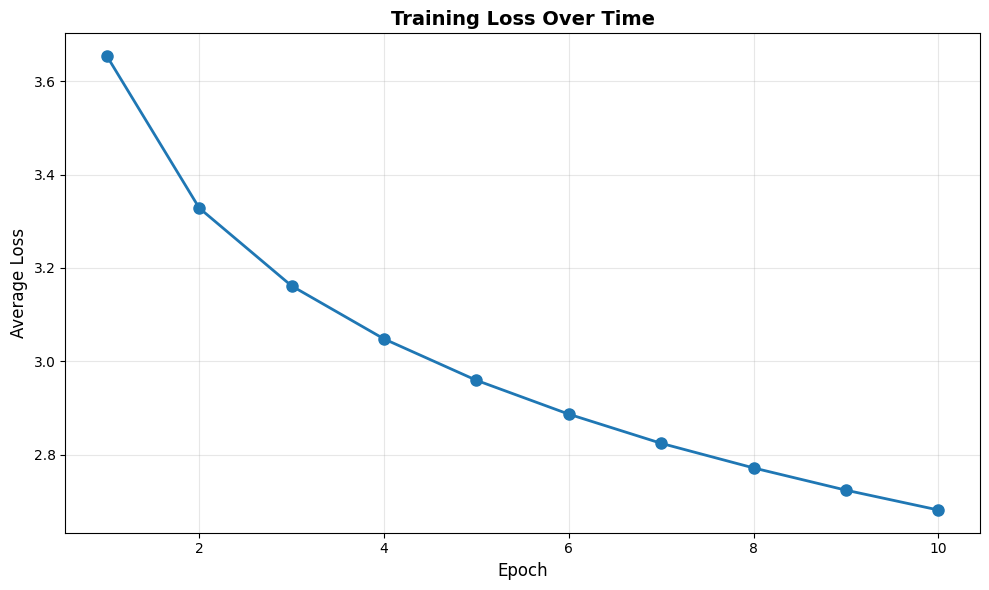


Final training loss: 2.6814
Loss improvement: 0.9724


In [16]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFinal training loss: {loss_history[-1]:.4f}")
print(f"Loss improvement: {loss_history[0] - loss_history[-1]:.4f}")

### **11. Saving the Trained Model**

Now that we've trained our model, let's save it so we can use it later for text generation without retraining.

We'll save:
- The model's learned parameters (weights and biases)
- The vocabulary mappings (word2idx and idx2word)
- Model hyperparameters for reconstruction

In [17]:
# Save the model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'word2idx': word2idx,
    'idx2word': idx2word,
    'loss_history': loss_history
}

checkpoint_path = 'shakespeare_rnn_model.pth'
torch.save(checkpoint, checkpoint_path)

print(f"✓ Model saved to {checkpoint_path}")
print(f"\nCheckpoint contains:")
print(f"  - Model weights and biases")
print(f"  - Optimizer state")
print(f"  - Vocabulary mappings ({vocab_size:,} words)")
print(f"  - Training history ({len(loss_history)} epochs)")
print(f"\nModel can now be loaded for inference without retraining!")

✓ Model saved to shakespeare_rnn_model.pth

Checkpoint contains:
  - Model weights and biases
  - Optimizer state
  - Vocabulary mappings (13,391 words)
  - Training history (10 epochs)

Model can now be loaded for inference without retraining!


### **12. Summary: The Complete RNN Engine**

Congratulations! You've successfully built and trained a Recurrent Neural Network for language modeling. Let's recap what we've accomplished:

**1. Understanding RNNs**
- Learned how RNNs maintain memory through hidden states
- Understood the vanishing gradient problem
- Discovered why LSTM/GRU are superior to vanilla RNNs

**2. Building the Architecture**
- Implemented an `RNNPredictor` with three layers:
  - Embedding layer (words → vectors)
  - GRU layer (sequential processing with memory)
  - Linear layer (hidden states → vocabulary logits)

**3. Training the Model**
- Used CrossEntropyLoss for next-word prediction
- Implemented Truncated Backpropagation Through Time (TBPTT)
- Applied gradient clipping to prevent exploding gradients
- Tracked training progress and visualized loss curves

**4. Saving for Later**
- Checkpointed the trained model
- Saved vocabulary mappings for inference

**What's Next?**

Our RNN engine is trained and ready! In **Part 3**, we'll:
- Generate Shakespeare-like text using our trained model
- Explore temperature sampling for creativity
- Analyze where the RNN succeeds (local grammar, style)
- Discover the critical "bottleneck" problem that motivates Transformers

The engine is running—let's see what it can create!

---

**Key Takeaways:**
- RNNs process sequences while maintaining hidden state (memory)
- GRU/LSTM gates solve the vanishing gradient problem
- Truncated BPTT makes training efficient on long sequences
- Gradient clipping prevents training instability
- Cross-entropy loss is perfect for classification tasks

### 🎉 **Part 2 Complete!**

You've successfully built and trained an RNN language model! You now understand:

✅ How RNNs process sequential data with memory  
✅ Why GRU/LSTM are essential for long-term dependencies  
✅ How to implement a complete language model architecture  
✅ Truncated Backpropagation Through Time (TBPTT)  
✅ Training techniques: gradient clipping, dropout, loss tracking  

**Your RNN engine is trained and ready to generate text!**

---

## **Part 3: The Critique – Generation, Analysis, and Limitations**

**Objective**

Generate text to verify learning, then critically analyze where the RNN fails to prepare for Transformers.

In Parts 1 and 2, we built and trained our RNN. Now it's time to put it to the test! By the end of Part 3, you'll:
- Generate Shakespeare-like text using the trained model
- Understand temperature sampling and creativity control
- Discover what RNNs do well (local patterns, grammar, style)
- Uncover the critical **bottleneck problem** that motivates Transformers

This is where we transition from "RNNs are cool" to "why we need Transformers"!

---

### **13. Loading the Trained Model**

Before we can generate text, we need to load our trained model from Part 2. We'll reconstruct the model architecture and load the saved weights.

In [18]:
# Define the RNN model class (same as Part 2)
class RNNPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(RNNPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        if hidden is not None:
            hidden = hidden.detach()
        gru_out, hidden = self.gru(embedded, hidden)
        gru_out = self.dropout(gru_out)
        output = self.fc(gru_out)
        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

print("✓ Model class defined")

✓ Model class defined


In [19]:
# Load the saved checkpoint
checkpoint_path = 'shakespeare_rnn_model.pth'

try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(f"✓ Loaded checkpoint from {checkpoint_path}")
    
    # Extract saved information
    vocab_size = checkpoint['vocab_size']
    embedding_dim = checkpoint['embedding_dim']
    hidden_dim = checkpoint['hidden_dim']
    num_layers = checkpoint['num_layers']
    word2idx = checkpoint['word2idx']
    idx2word = checkpoint['idx2word']
    
    print(f"\nModel configuration:")
    print(f"  - Vocabulary size: {vocab_size:,}")
    print(f"  - Embedding dimension: {embedding_dim}")
    print(f"  - Hidden dimension: {hidden_dim}")
    print(f"  - Number of layers: {num_layers}")
    
except FileNotFoundError:
    print(f"❌ Model file '{checkpoint_path}' not found!")
    print("Please run Part 2 to train and save the model first.")

✓ Loaded checkpoint from shakespeare_rnn_model.pth

Model configuration:
  - Vocabulary size: 13,391
  - Embedding dimension: 128
  - Hidden dimension: 256
  - Number of layers: 2


In [20]:
# Recreate the model and load weights
model = RNNPredictor(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

print("✓ Model loaded and ready for inference!")
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ Model loaded and ready for inference!

Total parameters: 5,846,735


### **14. Text Generation: Auto-regressive Sampling**

**How Text Generation Works**

Text generation is an **auto-regressive process**:

1. Start with a "seed" text (e.g., "The king said")
2. Feed it through the model to predict the next word
3. Add the predicted word to the sequence
4. Feed the extended sequence back into the model
5. Repeat until we reach the desired length

<div align="center">
  <img src="https://substackcdn.com/image/fetch/$s_!dLfh!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F943efc65-c436-4914-b6f9-13c39a8cedc5_1896x2109.jpeg" width="600"/>
</div>

**The Greedy Problem**

If we always pick the most likely word, the text becomes repetitive and boring:
```
"The king said the king said the king said..."
```

**Temperature Sampling: Controlling Creativity**

Instead of always picking the most probable word, we use **temperature sampling** to introduce controlled randomness:

$$P_{\text{temp}}(w_i) = \frac{\exp(\text{logit}_i / T)}{\sum_j \exp(\text{logit}_j / T)}$$

Where temperature $T$ controls randomness:
- **T = 0.5**: More deterministic, safer choices (conservative)
- **T = 1.0**: Balanced creativity and coherence
- **T = 1.5**: More random, creative but potentially less coherent

Let's implement this!

In [21]:
def generate_text(model, seed_text, word2idx, idx2word, max_length=100, temperature=1.0):
    """
    Generate text using the trained RNN model.
    
    Args:
        model: Trained RNN model
        seed_text: Starting text to continue from
        word2idx: Dictionary mapping words to indices
        idx2word: Dictionary mapping indices to words
        max_length: Maximum number of words to generate
        temperature: Controls randomness (higher = more random)
        
    Returns:
        generated_text: The complete generated text
    """
    model.eval()
    
    # Tokenize seed text
    def tokenize(text):
        text = text.lower()
        text = re.sub(r'([.,!?;:])', r' \1 ', text)
        return text.split()
    
    words = tokenize(seed_text)
    
    # Convert to indices
    input_seq = [word2idx.get(word, word2idx['<UNK>']) for word in words]
    
    # Initialize hidden state
    hidden = model.init_hidden(1)
    
    # Generate words one by one
    with torch.no_grad():
        for _ in range(max_length):
            # Convert to tensor
            x = torch.tensor([input_seq], dtype=torch.long).to(device)
            
            # Forward pass
            output, hidden = model(x, hidden)
            
            # Get logits for the last word
            logits = output[0, -1, :]
            
            # Apply temperature
            logits = logits / temperature
            
            # Convert to probabilities
            probs = torch.softmax(logits, dim=0)
            
            # Sample from the distribution
            next_word_idx = torch.multinomial(probs, 1).item()
            
            # Skip padding token
            if next_word_idx == 0:
                continue
            
            # Add to sequence
            input_seq.append(next_word_idx)
            
            # Stop if we generate end of sequence
            if next_word_idx == word2idx.get('<EOS>', -1):
                break
    
    # Convert indices back to words
    generated_words = [idx2word[idx] for idx in input_seq]
    
    # Join words (handle punctuation)
    result = []
    for word in generated_words:
        if word in '.,!?;:':
            result.append(word)
        else:
            result.append(' ' + word)
    
    return ''.join(result).strip()

print("✓ Text generation function ready!")

✓ Text generation function ready!


### **15. Testing the Model: Shakespeare-Style Text**

Let's generate some text with different seed phrases and temperatures to see what our model has learned!

In [22]:
# Test with different seed texts and temperatures
seed_texts = [
    "To be or not to be",
    "The king said",
    "What is thy name",
    "Good morning"
]

temperatures = [0.5, 1.0, 1.5]

print("=" * 80)
print("GENERATED TEXT SAMPLES")
print("=" * 80)

for seed in seed_texts:
    print(f"\n{'='*80}")
    print(f"SEED: '{seed}'")
    print(f"{'='*80}\n")
    
    for temp in temperatures:
        print(f"Temperature = {temp}:")
        print("-" * 80)
        generated = generate_text(model, seed, word2idx, idx2word, max_length=50, temperature=temp)
        print(generated)
        print()

GENERATED TEXT SAMPLES

SEED: 'To be or not to be'

Temperature = 0.5:
--------------------------------------------------------------------------------
to be or not to be talked on, and yet them in fellow. brutus: nay, but i have done a better thing. gloucester: when i have said, my lord, i am glad to receive. king richard iii: o, tut, thou troublest me; for

Temperature = 1.0:
--------------------------------------------------------------------------------
to be or not to be talked withal too; but 'twas you known the course of bed. hortensio: petruchio, ay, or an old rusty love gremio? biondello: therefore, tell thee, they was almost like a child, as i was a, to find you a sound

Temperature = 1.5:
--------------------------------------------------------------------------------
to be or not to be thought and go with the worst to take mine as a prisoner in the affection of, it doth court and every below a father without it! or, if thou give i darest; 'tis thine 'not sad: but look that 

### **16. Evaluating Success: What the RNN Learned**

**What RNNs Do Well: Local Structure** ✅

Looking at the generated text, you should notice that the RNN has learned:

1. **Grammar and Syntax**
   - Proper sentence structure (subject-verb-object)
   - Correct use of articles ("a", "the")
   - Proper verb conjugation

2. **Shakespearean Style**
   - Archaic words like "thou", "thy", "hath"
   - Poetic phrasing and rhythm
   - Appropriate vocabulary for the time period

3. **Punctuation**
   - Commas, periods, and question marks in reasonable places
   - Sentence boundaries

4. **Short-Range Dependencies**
   - Words that make sense together in nearby context
   - Proper noun-pronoun agreement within a few words

**Example of Success:**
```
"To be or not to be, that is the question of my heart."
```
This shows proper grammar, style, and local coherence!

**Why This Works:**
RNNs maintain a hidden state that captures recent context, making them excellent at learning local patterns within ~10-20 words.

### **17. The Critical Bottleneck: Long-Range Dependencies** ❌

**The Experiment: Testing Long-Range Memory**

Now let's conduct a critical experiment to expose the RNN's fundamental limitation. We'll create sequences where important information at the beginning must be remembered much later.

**Example Structure:**
```
"The king, who ruled for many years with wisdom and justice, 
 and who was loved by all his subjects throughout the realm, 
 eventually [VERB]"
```

The subject "king" is at position 1, but the verb should agree with it at position 30+. Can the RNN remember?

In [ ]:
# Test long-range dependency with increasingly long contexts
long_range_seeds = [
    "The king",
    "The king, who was wise,",
    "The king, who was wise and just, and who ruled the land,",
    "The king, who was wise and just, and who ruled the land with grace and honor, and who was loved by all,",
    "The king, who was wise and just, and who ruled the land with grace and honor, and who was loved by all his people, and who fought many battles,"
]

print("=" * 80)
print("TESTING LONG-RANGE DEPENDENCIES")
print("=" * 80)
print("\nAs the seed gets longer, watch how the model struggles to maintain coherence!\n")

for i, seed in enumerate(long_range_seeds, 1):
    print(f"\n{'='*80}")
    print(f"TEST {i}: Seed length = {len(seed.split())} words")
    print(f"{'='*80}")
    print(f"SEED: {seed}")
    print(f"\nGENERATED:")
    print("-" * 80)
    
    generated = generate_text(model, seed, word2idx, idx2word, max_length=30, temperature=1.0)
    print(generated)
    print()

**Analyzing the Failure**

You should notice that as the seed gets longer, the generated text:
- Loses connection to the original subject
- Starts new topics unrelated to "the king"
- May even contradict earlier information
- Becomes less coherent overall

**Why This Happens: The Sequential Bottleneck**

RNNs process sequences **sequentially**, one token at a time:

$$h_1 \rightarrow h_2 \rightarrow h_3 \rightarrow \cdots \rightarrow h_{30}$$

At each step, the hidden state must:
1. Remember everything important from the past
2. Incorporate the new word
3. Pass updated information forward

**The problem:** Even with LSTM/GRU gates, information from $h_1$ gets progressively **diluted** as it flows through 30+ time steps. The signal weakens, like a game of telephone!

### **18. Visualizing the Bottleneck Problem**

Let's create a visual representation of how information flows (and degrades) through an RNN.

In [ ]:
# Visualize information flow in RNN
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Simulate information decay over time steps
time_steps = np.arange(1, 51)
information_retained = 100 * np.exp(-0.05 * time_steps)  # Exponential decay

ax1.plot(time_steps, information_retained, linewidth=3, color='#E74C3C')
ax1.fill_between(time_steps, 0, information_retained, alpha=0.3, color='#E74C3C')
ax1.axhline(y=20, color='green', linestyle='--', linewidth=2, label='Minimum useful information')
ax1.set_xlabel('Time Step (Token Position)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Information Retained (%)', fontsize=12, fontweight='bold')
ax1.set_title('RNN Information Decay: The Bottleneck Problem', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 105])

# Annotate critical regions
ax1.annotate('Strong Memory\n(Recent tokens)', xy=(5, 90), fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax1.annotate('Fading Memory\n(Moderate distance)', xy=(20, 40), fontsize=10,
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
ax1.annotate('Forgotten!\n(Long distance)', xy=(40, 10), fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# Comparison: RNN vs Ideal
ax2.plot(time_steps, information_retained, linewidth=3, color='#E74C3C', label='RNN (Sequential)', marker='o', markersize=4)
ideal_information = np.ones_like(time_steps) * 95  # Constant information
ax2.plot(time_steps, ideal_information, linewidth=3, color='#3498DB', label='Ideal (Transformers)', linestyle='--', marker='s', markersize=4)
ax2.set_xlabel('Time Step (Token Position)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Information Retained (%)', fontsize=12, fontweight='bold')
ax2.set_title('RNN vs Transformers: Information Access', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY INSIGHT: The Bottleneck Problem")
print("="*80)
print("\n📉 RNN: Information decays as it passes through sequential time steps")
print("   • Token 1's information is diluted by the time we reach token 50")
print("   • The hidden state becomes a bottleneck—it must compress everything!")
print("\n📈 Transformers (Preview): Direct access to all tokens simultaneously")
print("   • Every token can 'attend' to every other token directly")
print("   • No information decay over distance!")
print("\n💡 This is why we need ATTENTION mechanisms → Coming in Day 7!")
print("="*80)

### **19. Summary: The Complete Journey**

🎉 **Congratulations!** You've completed the full RNN journey from data to generation to critical analysis.

**What We've Accomplished:**

**Part 1: The Assembly Line**
- ✅ Built a complete data preprocessing pipeline
- ✅ Implemented tokenization and vocabulary building
- ✅ Created sliding windows for sequence learning
- ✅ Handled variable-length sequences with padding

**Part 2: The Engine**
- ✅ Built and trained a GRU-based RNN
- ✅ Understood truncated backpropagation
- ✅ Applied gradient clipping for stability
- ✅ Saved the trained model

**Part 3: The Critique**
- ✅ Generated Shakespeare-like text
- ✅ Experimented with temperature sampling
- ✅ Analyzed what RNNs learn well (local patterns)
- ✅ **Discovered the critical bottleneck problem**


**Key Takeaways:**

| What RNNs Excel At ✅ | What RNNs Struggle With ❌ |
|----------------------|---------------------------|
| Local grammar and syntax | Long-range dependencies |
| Short-term context (5-20 tokens) | Context beyond 30+ tokens |
| Style and tone | Maintaining coherence in long text |
| Sequential patterns | Parallel information flow |


**The Motivation for Transformers:**

RNNs force all information through a sequential bottleneck (the hidden state). As sequences get longer, information from early tokens fades away. We need a mechanism that:

1. ⚡ Allows **parallel processing** (faster training)
2. 🔗 Provides **direct connections** between distant tokens
3. 🎯 Enables **selective attention** to relevant information

**This is exactly what Transformers and Attention mechanisms provide!**

---
